In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore',category=FutureWarning)



In [2]:
#Loading the dataset
df = pd.read_csv('Dataset .csv')

In [3]:
#Selecting the necessary features
df_features = ['Restaurant Name','Country Code','Average Cost for two','Has Table booking',
 'Has Online delivery',
 'Is delivering now','Price range','Aggregate rating','Votes','Cuisines']

In [4]:
#Making updates to the dataset
df = df[df_features].copy()

In [5]:
#Checking any zeros before cleaning
(df==0).sum()

Restaurant Name            0
Country Code               0
Average Cost for two      18
Has Table booking          0
Has Online delivery        0
Is delivering now          0
Price range                0
Aggregate rating        2148
Votes                   1094
Cuisines                   0
dtype: int64

In [6]:
#Checking any na before cleaning
df.isna().sum()

Restaurant Name         0
Country Code            0
Average Cost for two    0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Price range             0
Aggregate rating        0
Votes                   0
Cuisines                9
dtype: int64

In [7]:
# Extract Primary Cuisine for analysis (but Cuisines remains target)
print(f"\nExtracting Primary Cuisine for analysis...")
df['Primary_Cuisine'] = df['Cuisines'].astype(str).str.split(',').str[0].str.strip()
df = df[df['Primary_Cuisine'].str.len() > 0].copy()
print(f"- Primary cuisines extracted: {df['Primary_Cuisine'].nunique()} unique")
print(f"- Top primary cuisines:")
print(df['Primary_Cuisine'].value_counts().head())


Extracting Primary Cuisine for analysis...
- Primary cuisines extracted: 120 unique
- Top primary cuisines:
Primary_Cuisine
North Indian    2992
Chinese          855
Fast Food        672
Bakery           621
Cafe             617
Name: count, dtype: int64


In [8]:
#Dealing with missing values ,zeros ,na values with the features

df['Aggregate rating'] = pd.to_numeric(df['Aggregate rating'], errors='coerce')


initial_rows = len(df)
df =df[(df['Aggregate rating'].notnull()) & (df['Aggregate rating'] != 0)].copy()
print(f"Dropped {initial_rows - len(df)} rows with zero aggregate rating")





Dropped 2148 rows with zero aggregate rating


In [9]:
df['Average Cost for two'] = pd.to_numeric(df['Average Cost for two'],errors='coerce')
df['Average Cost for two'] = df['Average Cost for two'].replace(0,np.nan)
df['Average Cost for two'] = df['Average Cost for two'].fillna(df['Average Cost for two'].median())

In [10]:
# Drop rows with missing Cuisines (our target)
print(f"\nHandling target variable (Cuisines) missing values...")
initial_rows = len(df)
df = df.dropna(subset=['Cuisines']).copy()
final_rows = len(df)
print(f"- Dropped {initial_rows - final_rows} rows with missing Cuisines")
print(f"- Final dataset shape: {df.shape}")


Handling target variable (Cuisines) missing values...
- Dropped 9 rows with missing Cuisines
- Final dataset shape: (7394, 11)


In [11]:
# Check missing values after handling
print(f"\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
Restaurant Name         0
Country Code            0
Average Cost for two    0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Price range             0
Aggregate rating        0
Votes                   0
Cuisines                0
Primary_Cuisine         0
dtype: int64


In [12]:
#Setting our cuisines to shorter range for better classification
top_n = 10
top_cuisines = df['Primary_Cuisine'].value_counts().nlargest(top_n).index
df['Primary_Cuisine'] = df['Primary_Cuisine'].where(df['Primary_Cuisine'].isin(top_cuisines),'Other')

In [13]:
df['text_features'] = df['Restaurant Name'].astype(str) + '' +df['Cuisines'].astype(str)

In [14]:
#defining cols for categories
text_features = 'text_features'
binary_features = ['Has Table booking','Has Online delivery','Is delivering now']
numeric_features = ['Average Cost for two','Price range','Votes','Aggregate rating']
country_col = 'Country Code'
target_col ='Primary_Cuisine'

In [15]:
df['Country Code'] = df[country_col].astype(str)

In [16]:
# Analyze Country Code distribution for best encoding choice
print(f"\nAnalyzing Country Code for optimal encoding:")
print(f"- Unique countries: {df['Country Code'].nunique()}")
print(f"- Distribution:")
country_dist = df['Country Code'].value_counts().head(10)
print(country_dist)


Analyzing Country Code for optimal encoding:
- Unique countries: 15
- Distribution:
Country Code
1      6513
216     422
215      79
214      60
189      60
30       55
148      40
208      34
14       24
162      22
Name: count, dtype: int64


In [17]:
#Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer

preprocessor = ColumnTransformer(transformers=[
    ('num',StandardScaler(),numeric_features),
    ('bin', OneHotEncoder(handle_unknown='ignore',drop='if_binary'), binary_features),
    ('country',OneHotEncoder(handle_unknown='ignore'),[country_col]),
    ('txt',HashingVectorizer(n_features=2000,alternate_sign=False,ngram_range=(1,2)),text_features),
],sparse_threshold=0)

In [18]:
preprocessor

,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df[target_col] = label_encoder.fit_transform(df[target_col])

In [20]:
# Splitting data
X = df[binary_features + numeric_features + [text_features]+[country_col]]
y = df[target_col]

In [21]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.19,random_state=42,stratify=y)

In [22]:
print(f" X_train: {X_train.shape}\n y_train: {y_train.shape}\n X_test: {X_test.shape}\n y_test: {y_test.shape}")

 X_train: (5989, 9)
 y_train: (5989,)
 X_test: (1405, 9)
 y_test: (1405,)


In [23]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [24]:

# Training the models
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42,class_weight='balanced',n_estimators=300,max_depth=None,min_samples_leaf=5,n_jobs=-1)



In [25]:
rf.fit(X_train_transformed,y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42,max_depth=6,min_samples_leaf=5,criterion='entropy')
dt.fit(X_train_transformed,y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [27]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(random_state=42,n_estimators =200,max_depth=6,min_samples_leaf=5,criterion='entropy',n_jobs=-1)
et.fit(X_train_transformed,y_train)

,n_estimators,200
,criterion,'entropy'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
knn.fit(X_train_transformed,y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,-1


In [29]:
print(type(y_train.iloc[0]), y_train.unique()[:15])



<class 'numpy.int64'> [ 2  7  8  3  1  9  5  6 10  4  0]


In [30]:
#Training XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='multi:softmax',num_class=len(label_encoder.classes_),eval_metric='mlogloss',learning_rate=0.1,random_state=42,n_estimators=300,max_depth=6)

xgb.fit(X_train_transformed,y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [31]:
#Making predictions for each model
y_pred_rf = rf.predict(X_test_transformed)
y_pred_dt = dt.predict(X_test_transformed)
y_pred_et = et.predict(X_test_transformed)
y_pred_knn = knn.predict(X_test_transformed)
y_pred_xgb = xgb.predict(X_test_transformed)

In [32]:
y_prob_rf = rf.predict_proba(X_test_transformed)
y_prob_dt = dt.predict_proba(X_test_transformed)
y_prob_et = et.predict_proba(X_test_transformed)
y_prob_knn = knn.predict_proba(X_test_transformed)
y_prob_xgb = xgb.predict_proba(X_test_transformed)

In [33]:
#Evaluation Function
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,classification_report
def evaluate_score(name,y_true,y_pred,y_pred_prob =None,average = 'weighted'):
    print('name:',name)

    #Accuracy
    print(f"Accuracy_Score: {accuracy_score(y_true,y_pred):.3f}")
    #F1 Score
    print(f"F1 Score: {f1_score(y_true,y_pred,average=average):.3f}")
    #ROC AUC
    if y_pred_prob is not None:
        try:
            classes = np.unique(y_true)
            y_true_bin =label_binarize(y_true,classes =classes)
            if y_pred_prob .shape[1] == len(classes):
                roc =roc_auc_score(y_true_bin,y_pred_prob,average=average,multi_class='ovr')
                print(f"ROC AUC Score ({average},ovr): {roc:.3f}")
            else:
                print("y_pred_prob columns don't match number of classes")
        except Exception as e:
            print(f"ROC AUC is not available {e}")

    #Classification report
    print("\n Classification Report")
    print(classification_report(y_true,y_pred,zero_division=0))




In [34]:
evaluate_score('Random Forest Classifier',y_test,y_pred_rf,y_prob_rf)

name: Random Forest Classifier
Accuracy_Score: 0.623
F1 Score: 0.600
ROC AUC Score (weighted,ovr): 0.948

 Classification Report
              precision    recall  f1-score   support

           0       0.36      0.88      0.51        51
           1       0.46      0.88      0.61        82
           2       0.69      0.74      0.71       104
           3       0.70      0.47      0.56       116
           4       0.25      0.77      0.38        43
           5       0.57      0.86      0.68        91
           6       0.31      0.51      0.39        41
           7       0.93      0.89      0.91       420
           8       0.97      0.17      0.29       382
           9       0.57      0.64      0.61        36
          10       0.38      0.82      0.52        39

    accuracy                           0.62      1405
   macro avg       0.56      0.69      0.56      1405
weighted avg       0.77      0.62      0.60      1405



In [35]:
evaluate_score('Decision Tree Classifer',y_test,y_pred_dt,y_prob_dt)

name: Decision Tree Classifer
Accuracy_Score: 0.662
F1 Score: 0.614
ROC AUC Score (weighted,ovr): 0.915

 Classification Report
              precision    recall  f1-score   support

           0       0.86      0.37      0.52        51
           1       0.79      0.41      0.54        82
           2       1.00      0.01      0.02       104
           3       0.40      0.07      0.12       116
           4       0.65      0.47      0.54        43
           5       0.79      0.76      0.78        91
           6       0.71      0.12      0.21        41
           7       0.93      0.98      0.96       420
           8       0.46      0.86      0.60       382
           9       1.00      0.39      0.56        36
          10       0.78      0.46      0.58        39

    accuracy                           0.66      1405
   macro avg       0.76      0.45      0.49      1405
weighted avg       0.73      0.66      0.61      1405



In [36]:
evaluate_score('ExtraTree Classifier',y_test,y_pred_et,y_prob_et)

name: ExtraTree Classifier
Accuracy_Score: 0.512
F1 Score: 0.400
ROC AUC Score (weighted,ovr): 0.930

 Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.00      0.00      0.00        82
           2       1.00      0.12      0.22       104
           3       0.00      0.00      0.00       116
           4       0.00      0.00      0.00        43
           5       1.00      0.12      0.22        91
           6       0.00      0.00      0.00        41
           7       0.52      1.00      0.68       420
           8       0.48      0.69      0.56       382
           9       1.00      0.36      0.53        36
          10       0.00      0.00      0.00        39

    accuracy                           0.51      1405
   macro avg       0.36      0.21      0.20      1405
weighted avg       0.45      0.51      0.40      1405



In [37]:
evaluate_score('KNeighbours Classifier',y_test,y_pred_knn,y_prob_knn)

name: KNeighbours Classifier
Accuracy_Score: 0.666
F1 Score: 0.658
ROC AUC Score (weighted,ovr): 0.884

 Classification Report
              precision    recall  f1-score   support

           0       0.41      0.55      0.47        51
           1       0.68      0.68      0.68        82
           2       0.56      0.63      0.59       104
           3       0.51      0.41      0.45       116
           4       0.30      0.30      0.30        43
           5       0.63      0.69      0.66        91
           6       0.54      0.32      0.40        41
           7       0.76      0.93      0.84       420
           8       0.73      0.57      0.64       382
           9       0.73      0.53      0.61        36
          10       0.56      0.59      0.57        39

    accuracy                           0.67      1405
   macro avg       0.58      0.56      0.57      1405
weighted avg       0.66      0.67      0.66      1405



In [38]:
evaluate_score('XGBoost classifeir',y_test,y_pred_xgb,y_prob_xgb)

name: XGBoost classifeir
Accuracy_Score: 0.810
F1 Score: 0.807
ROC AUC Score (weighted,ovr): 0.971

 Classification Report
              precision    recall  f1-score   support

           0       0.79      0.67      0.72        51
           1       0.92      0.72      0.81        82
           2       0.80      0.75      0.77       104
           3       0.71      0.62      0.66       116
           4       0.69      0.47      0.56        43
           5       0.78      0.88      0.82        91
           6       0.81      0.54      0.65        41
           7       0.95      0.99      0.97       420
           8       0.69      0.80      0.74       382
           9       0.93      0.72      0.81        36
          10       0.89      0.64      0.75        39

    accuracy                           0.81      1405
   macro avg       0.81      0.71      0.75      1405
weighted avg       0.81      0.81      0.81      1405



In [39]:
#Defining the best models

from sklearn.ensemble import VotingClassifier

best_model =VotingClassifier(
    estimators =[
        ('rf',rf),
        ('dt',dt),
        ('et',et),
        ('knn',knn),
    ],
    voting='hard',
)

#training the ensemble
best_model.fit(X_train_transformed,y_train)


,estimators,"[('rf', ...), ('dt', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5


In [40]:
y_pred = best_model.predict(X_test_transformed)

In [41]:
#Evaluation:
print("Accuracy:",accuracy_score(y_test,y_pred))
print("F1 Score:",f1_score(y_test,y_pred,average='weighted'))
print("\nClassification Report \n",classification_report(y_test,y_pred))

Accuracy: 0.7138790035587189
F1 Score: 0.6993788881967778

Classification Report 
               precision    recall  f1-score   support

           0       0.57      0.55      0.56        51
           1       0.62      0.78      0.69        82
           2       0.72      0.62      0.67       104
           3       0.72      0.36      0.48       116
           4       0.41      0.49      0.45        43
           5       0.76      0.81      0.78        91
           6       0.81      0.32      0.46        41
           7       0.80      0.99      0.89       420
           8       0.64      0.65      0.64       382
           9       1.00      0.42      0.59        36
          10       0.89      0.44      0.59        39

    accuracy                           0.71      1405
   macro avg       0.72      0.58      0.62      1405
weighted avg       0.72      0.71      0.70      1405



In [42]:
for true_label,pred_label in zip(y_test[:5],y_pred[:5]):
    print(f"Actual:{true_label} Predicted:{pred_label}")

Actual:9 Predicted:9
Actual:8 Predicted:8
Actual:3 Predicted:3
Actual:7 Predicted:7
Actual:8 Predicted:8


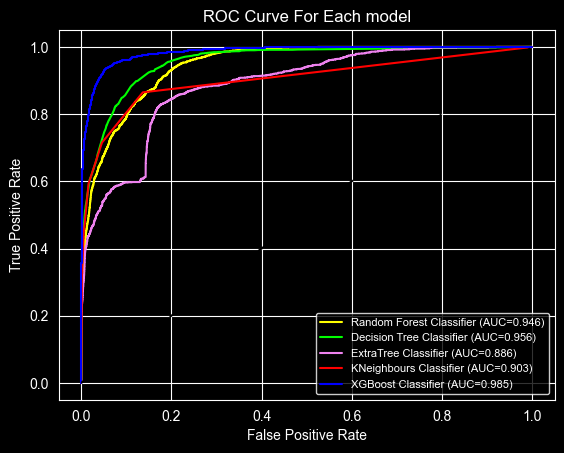

In [43]:
#Visualization for roc_auc curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,RocCurveDisplay,auc

models ={
    'Random Forest Classifier':rf,
    'Decision Tree Classifier':dt,
    'ExtraTree Classifier':et,
    'KNeighbours Classifier':knn,
    'XGBoost Classifier':xgb,
}

plt.style.use('dark_background')
colors={
    'Random Forest Classifier':'yellow',
    'Decision Tree Classifier':'lime',
    'ExtraTree Classifier':'violet',
    'KNeighbours Classifier':'red',
    'XGBoost Classifier':'blue',
}


for name,model in models.items():
    if hasattr(model,'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_transformed)
        y_test_bin = label_binarize(y_test,classes =np.unique(y_test))

        #Computing roc for all classes
        fpr,tpr,_ = roc_curve(y_test_bin.ravel(),y_pred_proba.ravel())
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr,tpr,color= colors[name],label =f"{name} (AUC={roc_auc:.3f})")


plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Each model')
plt.legend(fontsize=8,loc='lower right',frameon=True,facecolor='black',edgecolor='white')
plt.show()

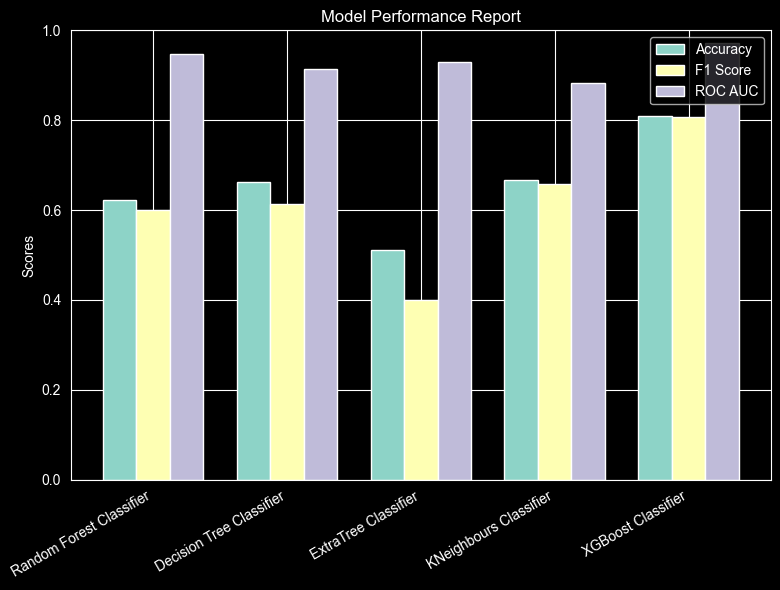

In [46]:
#Model performance comparison report
import matplotlib.pyplot as plt

plt.style.use('dark_background')

#Grouped bar charts
accuracies = [0.623,0.662,0.512,0.666,0.810]
f1_Scores = [0.600,0.614,0.400,0.658,0.807]
roc_auc_scores =[0.948,0.915,0.930,0.884,0.971]

x= np.arange(len(models))
width =0.25
plt.figure(figsize= (8,6))
plt.bar(x-width,accuracies,width,label='Accuracy')
plt.bar(x,f1_Scores,width,label='F1 Score')
plt.bar(x+width,roc_auc_scores,width,label='ROC AUC')

plt.xticks(x,models,rotation=30,ha='right')
plt.ylabel('Scores')
plt.ylim(0,1)
plt.title('Model Performance Report')
plt.legend()
plt.tight_layout()
plt.show()

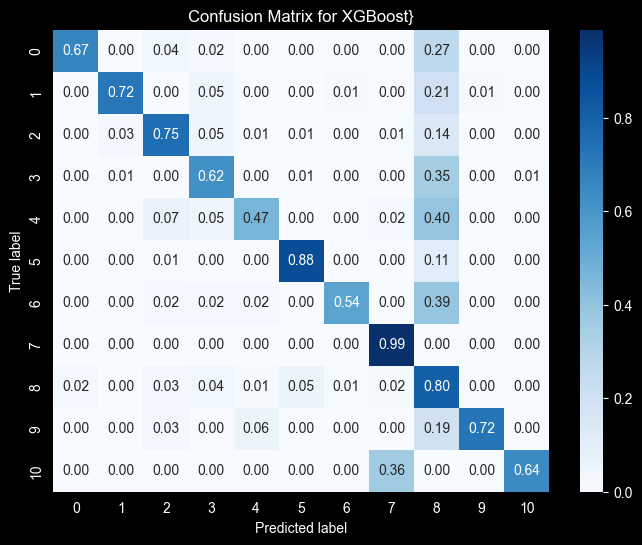

In [47]:
#Confusion matrix for the best model:xgboost
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test,y_pred_xgb,labels =np.unique(y_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize= (8,6))
sns.heatmap(cm_normalized,annot=True,fmt='.2f',cmap='Blues',xticklabels=np.unique(y_test),yticklabels=np.unique(y_test))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion Matrix for XGBoost}")
plt.show()